#Second Practical work

This is second practical work skeleton.

It is divided in 3 parts_

1.   Python module load section: load all the needed modules
2.   Google Drive access and mounting
3.   Host load data
4.   GPU load





##Module load section
We will install the pycuda module in the colaboratory environment, to combine python and CUDA in our code. Because pycuda is not available by default, this task can take a few minutes.

As well we load numpy and matplotlib modules.

In [1]:
!pip install pycuda

     |████████████████████████████████| 1.7 MB 13.0 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 66 kB 5.3 MB/s 
     |████████████████████████████████| 75 kB 4.5 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627577 sha256=ce0b0247f7ef48baa32e608b1009ffaae8ee508e73fd7a0b82bf773c5f5ea63b
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
  Created wheel for pytools: filename=pytools-2021.2.9-py2.py3-none-any.whl size=62370 sha256=92c05c7ddcf8475bb3f67b6fd5237c9c0b3c4102e4e0668e2ba870d336fd0ad4
  Stored in directory: /root/.cache/pip/wheels/41/b9/6e/94bb014f6484b15ec77e7877f3a227609481ffd98db364504d
Successfully built pycuda pytools


We import the Python modules which we will use in the notebook (numpy, pycuda and time module) 

In [2]:
import  numpy  as  np
import  pycuda.autoinit
from    pycuda.compiler import SourceModule
import  pycuda.driver as  drv
import  pycuda.gpuarray as  gpuarray
from sys import getsizeof
import time

In [3]:
%pylab inline
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cProfile

Populating the interactive namespace from numpy and matplotlib


##Mount Google Drive and access grant
We use Google API to allow access to our Google Drive.

For security and privacy reasons, this permission is temporally, and will be requested every time you restart the notebook. 

Your Google Drive will be mounted in the "/content/drive" folder. The first Folder will be "My Drive".

You have to copy your images to a folder in the "My Drive" folder in your Google Drive.

To check your available files, use the cell indicated as "**List Files in Folder**"

In [4]:
from os.path import join
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
MYDRIVE="/content/drive/MyDrive/"

**List Files in Folders**

In [6]:
!ls /content/drive/My\ Drive/images

chess.jpg  lena.png  test2.png	testImage.jpg


We define a variable IMAGE which is constructed joining the "MYDRIVE" varible plus the final path to your image.

In [75]:
IMAGE=join(MYDRIVE,'images/lena.png')

In [76]:
print("Image to load: {0}".format(IMAGE))

Image to load: /content/drive/MyDrive/images/lena.png


Loads an image in a numpy variable, and show.

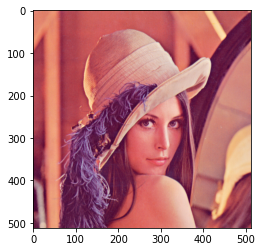

In [77]:
image=np.array(Image.open(IMAGE))
plt.figure()
plt.imshow(image)


#FILTER KERNEL

Here you have to define your image_filter GPU kernel.

In [78]:
kernel  =  SourceModule ("""
__global__ void image_filter( float * image,          //Source GPU array floating point 32 bits,
		                          float * filter_mask,    //Filter Mask GPU array 2D floating point 32 bits
                              float * filtered_image,  //Target GPU array 2D floating point 32 bits,
                              int NumRowsImg,          //Image Numrows,
                              int NumColsImg,          //Int32 Image Numcolumns,
                              int NumRowsFilter,       //Int32 Image NumRows filter mask,
                              int NumColsFilter        //Int32 Image NumCols filter mask
                              ) 
{ 
int WA = NumColsImg; 
int HA = NumRowsImg; 

// Define the kernel radius (the amount of cells that are used either right or less)

int HC = NumRowsFilter/2; 
int WC = NumColsFilter/2; 

const uint ts = 12;    // defines the tile size

// define image subdividision where the filters will be applied
__shared__ float imgMat[ 16 * 16 ];

// define thread and block indexes 
const uint tx = threadIdx.x;
const uint ty = threadIdx.y;

const uint bx = blockIdx.x;
const uint by = blockIdx.y;

// Define several indexes 

int col = bx * ts + tx ;
int row = by * ts + ty ; 

int row_i = row - HC; 
int col_i = col - WC;

// Fill the tile memory 

if (row_i< HA && row_i>=0 && col_i<WA && col_i>=0)
{
  imgMat[ty * blockDim.x + tx]= image[col_i + row_i * WA]; 
}
else 
{
  imgMat[ty * blockDim.x + tx] = 0;                        
}

__syncthreads();

// Computing of the filter itself 

float temp = 0.0f; 

if (ty < ts && tx < ts)
{ 
  temp = 0; 
  for (int i = 0; i < NumRowsFilter ; i++)
  {
    for (int j = 0; j < NumColsFilter ; j++)
    { 
      temp += filter_mask[j + i * NumColsFilter] * imgMat[(ty + i)* blockDim.x + (tx + j)];
    }
  }
  if (row < HA && col < WA)
  {
    filtered_image[col + row * WA] = temp; 
  }    
}  


}

""")

 ## Este es el codigo que nos dió el profe para copiar la imagen 

// This instruction calculate in the offset in the memory data, based on the block identificator blockIdx.x
    // YOU HAVE TO WRITE HERE YOUR FILTER KERNEL USING TILED MEMORY ALGORITHMS

    //THIS CODE JUST COPY THE SOURCE IMAGE IN THE TARGET VECTOR
    int idxY;
    int idxX;
    int vX;

    idxY = blockIdx.y*blockDim.y+threadIdx.y; //With this we calculate the row address in target matrix
    idxX = blockIdx.x*blockDim.x+threadIdx.x;
    if ((idxY<NumRowsImg) && (idxX<NumColsImg)){
      vX=idxY*NumColsImg+idxX;
      filtered_image[vX]=image[vX];
    }

## Este es el codigo que funciona parcialmente 

//This instruction calculate in the offset in the memory data, based on the block identificator blockIdx.x

    int WA = NumColsImg; 
    int HA = NumRowsImg; 
    int HC = NumRowsFilter; 
    int WC = NumColsFilter; 
    int WB = WA - WC +1; 
    int HB = HA - HC +1; 
    
    // define image subdividision where the filters will be applied
    __shared__ int imgMat[16*16];
  
    // define thread and block indexes 
    const uint tx = threadIdx.x;
    const uint ty = threadIdx.y;

    const uint bx = blockIdx.x;
    const uint by = blockIdx.y;

    // Define several indexes 

    int col = bx * (12) + tx ;
    int row = by * (12) + ty ; 

    int row_i = row - HC + 1 ; 
    int col_i = col - WC + 1 ;

    float temp = 0.0f ; 

    // Fill the tile memory 

    if ( row_i < HA && row_i >= 0 && col_i < WA && col_i >=0 )
    {
      imgMat[ty* 16 + tx] = image[col_i + row_i * WA ];  
    }
    else 
    {
      imgMat[ty* 16 + tx]= 0.0f; 
    }
    __syncthreads(); 

    if (ty < (12) && tx < (12)) 
    {
      for (int i = 0; i < HC ; i++)
      {
        for (int j = 0; j < WC ; j++ )
        {
          temp += filter_mask[j + i* WC] * imgMat[(ty + i)* 16 + tx + j] ;
        }
      }
    }

    if (row < HA && col < WA)
      {
        filtered_image[col + row * WA] = temp; 
      }    
}
    

## Código que funciona para copiar imagen


```
kernel  =  SourceModule ("""
__global__ void image_filter( float * image,          //Source GPU array floating point 32 bits,
		                          float * filter_mask,    //Filter Mask GPU array 2D floating point 32 bits
                              float * filtered_image,  //Target GPU array 2D floating point 32 bits,
                              int NumRowsImg,         //Image Numrows,
                              int NumColsImg,         //Int32 Image Numcolumns,
                              int NumRowsFilter,       //Int32 Image NumRows filter mask,
                              int NumColsFilter       //Int32 Image NumCols filter mask
                              ) 
{ 
int WA = NumColsImg; 
int HA = NumRowsImg; 
int HC = NumRowsFilter/2; 
int WC = NumColsFilter/2; 
int WB = WA - WC +1; 
int HB = HA - HC +1; 

// define image subdividision where the filters will be applied
__shared__ int imgMat[16*16];

// define thread and block indexes 
const uint tx = threadIdx.x;
const uint ty = threadIdx.y;

const uint bx = blockIdx.x;
const uint by = blockIdx.y;

// Define several indexes 

int col = bx * blockDim.x + tx ;
int row = by * blockDim.y + ty ; 

int row_i = row - HC + 1 ; 
int col_i = col - WC + 1 ;

// Fill the tile memory 

if ( row_i < HA && row_i >= 0 && col_i < WA && col_i >=0 )
{
  imgMat[ty* blockDim.x + tx] = image[col_i + row_i * WA];  
}
else 
{
  imgMat[ty* blockDim.x + tx]= 0.0f; 
}
__syncthreads();

float temp = 255.0f; 

if (ty < (blockDim.y) && tx < (blockDim.x)) 
{
  temp = imgMat[(ty) * blockDim.x + (tx)];  
}
if (row < HA && col < WA)
  {
    filtered_image[col + row * WA] = temp; 
  }    
}

""")
```



And import the kernel definition to python

In [79]:
image_filter = kernel.get_function ('image_filter')

Recover the image shape, and select the two first items (rows and columns).

In [80]:
image_shape=image.shape[0:2]

Set block size and grid size.

In [81]:
tile_size= 12
block_s=16 
block_size=(block_s,block_s,1)
grid_size=(int(np.ceil(image_shape[1]/tile_size)),int(np.ceil(image_shape[0]/tile_size)))

Allocates the target image memory.

In [82]:
result_image=np.zeros(image.shape,dtype=np.uint8)

In [83]:
depth = image.shape[2]

Here we defines our sample filter masks.

In [84]:
filter1=np.array([
    [0,0,0,0,0],
    [0,0,0,0,0],
    [0,0,1,0,0],
    [0,0,0,0,0],
    [0,0,0,0,0]
])
filter2=np.array([[0.5, 0 , -0.5]])
filter3=np.array([[0.5],[0],[-0.5]])

filter4=np.array([
    [1,0,-1],
    [2,0,-2],
    [1,0,-1]
])
filter5=np.array([
    [0.00078633,0.00655965,0.01330373,0.00655965,0.00078633],
    [0.00655965,0.05472157,0.11098164,0.05472157,0.00655965],
    [0.01330373,0.11098164,0.22508352,0.11098164,0.01330373],
    [0.00655965,0.05472157,0.11098164,0.05472157,0.00655965],
    [0.00078633,0.00655965,0.01330373,0.00655965,0.00078633]
])

We select the filter mask, and upload to the GPU device.

In [85]:
filter_mask=filter2.astype(np.float32)
filter_mask_gpu=gpuarray.to_gpu(filter_mask)
print(filter_mask_gpu)

[[ 0.5  0.  -0.5]]


##Prepares the execution environment 

Allocate the temporal filtered memory layer, where will be store the filtered image.

In [86]:
filtered_image_layer_gpu = gpuarray.zeros(image_shape,np.float32)
filtered_image_layer_gpu.shape

(512, 512)

Here defines the main block.
Walk through the layers. Copying the selected layer to temporal image_layer, upload the layer to the GPU and invokes the image_filter kernel.

In [87]:
start_t = time.time()
for layer in range(depth):
  image_layer = np.zeros(image_shape,dtype=np.float32) #Allocate the temporal image layer
  image_layer=(image[:,:,layer]).astype(np.float32)    #Copy from the orignal image the selected layer into the temporal memory
  image_layer_gpu=gpuarray.to_gpu(image_layer)         #Uploads the image layer to the GPU
  filtered_image_layer_gpu.fill(0.0)                   #Fills with 0 the target memory in the GPU
  image_filter(                                        #invokes the kernel
          image_layer_gpu,
          filter_mask_gpu,
          filtered_image_layer_gpu,
          np.int32(image_shape[0]),
          np.int32(image_shape[1]),
          np.int32(filter_mask.shape[0]),
          np.int32(filter_mask.shape[1]),
          block=block_size,
          grid=grid_size
        )
  filtered_image_layer=filtered_image_layer_gpu.get() #Download from the GPU the filtered image
  result_image[:,:,layer] = filtered_image_layer.astype(np.uint8) #Copy the filtered image to the final image store, 
                                                                  #casting the data type from double to uint8
end_t = time.time()

#Show results


In [36]:
print("Execution time is: {0} seconds.".format(end_t-start_t))

Execution time is: 0.006132364273071289 seconds.


Text(0.5, 1.0, 'Original image')

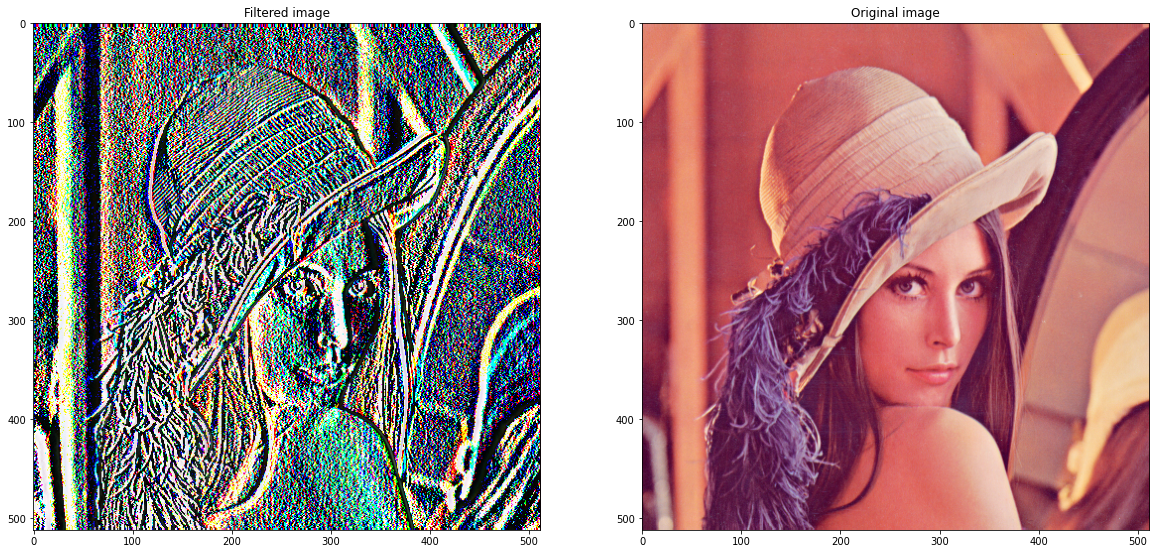

In [88]:
fig = plt.figure(figsize= (20,20))
result_image.shape
fig.add_subplot(1,2, 1)
plt.imshow(result_image)
plt.title('Filtered image')

fig.add_subplot(1,2, 2)
plt.imshow(image)
plt.title('Original image')